# EXERCISE 2

### AIM:
1. Gain familiarization on creating a custom agent and environment for the conflict detection and resolution problem (high level idea of interaction between the agent and the environment).
2. Explore the degree of variations that can be introduced in the environment by changing the conflict angles of the intruder and visualize by rendering the environment.
3. Evaluate the model convergence with tensorboard.
4. Tweak the reward parameters and see convergence performance.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd './drive/MyDrive/Exercises/Exercise 02'

/content/drive/MyDrive/Exercises/Exercise 02


Install required packages

In [3]:
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 14.5 MB/s eta 0:00:00


 Import the required libraries

In [4]:
%load_ext tensorboard
import gymnasium
from gymnasium import spaces
from PIL import Image
import numpy as np
import random
import matplotlib.pyplot as plt
# from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvasy


 Start a tensorboard session

In [5]:
%tensorboard --logdir=./Log/CustomEnv/ --host=localhost --port=8039

Output hidden; open in https://colab.research.google.com to view.

## Task 1


### Read the code with the agent and the environment class to understand the interaction betweem the agent and the environment

## Task 2:

### change the *init_angle* variable inside the agent class and render the environment
### Create the Agent class

In [6]:
"""the type of conflict .i.e head on or crossing conflict and also the degree of randomization can be changed
to generate scenarios of varying complexity.
Uncertainity in the position and speed of the aircraft can be added in the form of Gaussian noise to these parameters at the begin of each scenario
or at each step of a particular scenario.
But it must be ensured that the added uncertainties still lead to a LOS

"""
class Agent():
    def __init__(self,cx = 50, cy=50, r= 50, ownship = False ):
        self.icon = self.load_icon()
        self.CX = cx
        self.CY = cy
        self.R = r
        self.Ownship = ownship
        # self.offset = np.random.choice([-3, -2, -1, 1, 2, 3]) #

        if ownship == True:
            init_angle = np.pi
            x = int(r*np.cos(init_angle)+cx)
            y = int(r*np.sin(init_angle)+cy)
        else:
            # init_angle = (np.random.random()-0.5)*4*np.pi/3 # random position of intruder from -120 to 120 degree.
            # init_angle = np.random.choice([0, np.pi/6, np.pi/3, -np.pi/6, -np.pi/3]) # few choices of conflict angles
            init_angle = 0 # head-on conflict
            # init_angle = np.random.choice([-np.pi/2, np.pi/2]) # crossing conflict
            offset = 0
            x = int(r*np.cos(init_angle)+cx) + offset
            y = int(r*np.sin(init_angle)+cy) + offset

        self.position = np.array([x,y])
        self.heading = init_angle + np.pi
        self.speed = 10


    def step(self, new_heading):
        self.heading = new_heading

        self.position[0] = np.clip(self.position[0] + self.speed*np.cos(new_heading), 0, self.R*2)
        self.position[1] = np.clip(self.position[1] + self.speed*np.sin(new_heading), 0, self.R*2)
        return self.position

    def load_icon(self):
        filename = "./Icon/airplane.png"
        icon = Image.open(filename)
        return icon

### Create the custom environment


In [7]:


class CustomEnv(gymnasium.Env):
    CX, CY, R, SAFE_R = 50, 50, 50, 5


    LEFT, NONE, RIGHT = 1, 0, 2
    ALPHA = 0.25*np.pi # TURNING 45 degrees
    MAX_STEP = 1500
    high = 0.1*np.pi,

    def __init__(self, Reward_Params = [-0.2, 0, -10, -1, -10, 10]):
        self.Reward_Params = Reward_Params
        self.agents = [Agent(self.CX,self.CY,self.R, ownship=True), Agent(self.CX,self.CY,self.R)]
        self.reward = 0
        self.n_step = 0
        self.total_reward = 0
        n_observation = np.size(self.observation_func())
        n_action = 1

        self.action_space = spaces.Box(low=-self.ALPHA, high=+self.ALPHA, shape=(n_action, ), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=100, shape=(n_observation, ), dtype=np.float64)

    def reset(self,seed=0):
        self.agents = [Agent(ownship=True), Agent()]
        self.reward = 0
        self.n_step = 0
        self.total_reward = 0
        observation = self.observation_func()

        return observation, {}

    def step(self,action):
        self.n_step += 1

        # update ownship heading based on inputted action
        for i in range(len(self.agents)):
            x, y    = self.agents[i].position
            heading = self.agents[i].heading
            speed   = self.agents[i].speed

            if i == 0:
                heading = heading + action[0]

            # agent i moves to next position with updated heading
            self.agents[i].step(heading)

        self.done = self.check_stopping_condition()
        self.reward = self.reward_func(action,self.done)
        observation = self.observation_func()

        self.total_reward += self.reward # just for monitoring the model performance.
        ################################
        # Optionally we can pass additional info, we are not using that for now
        info = {}

        return observation, self.reward, self.done, False, info

    def check_stopping_condition(self):
        done = False
        x,y = self.agents[0].position

        # Compute the X and Y coordinations of the target region.
        x_thres     = self.R*np.cos(np.pi/36) + self.CX
        y_thres_min = self.R*np.sin(-np.pi/36) + self.CY
        y_thres_max = self.R*np.sin(np.pi/36) + self.CY

        dis = np.linalg.norm(self.agents[0].position - np.array([self.CX, self.CY]))

        # The ownship reaches the target region or the Episode steps reaches its limit.
        if ((self.R <= dis <= self.R+2) and (x >= x_thres) and (y_thres_min <= y <= y_thres_max)) or (self.n_step == self.MAX_STEP):
            return True

        return False

    def reward_func(self, action, done):
        """
        Reward = a1 * Reward_Step +
                 a2 * Reward_Deviation +
                 a3 * Reward_LOS +
                 a4 * Reward_Maneuvering +
                 a5 * Reward_Not_Reached +
                 a6 * Reward_Reached
        """
        a1 = self.Reward_Params[0]
        a2 = self.Reward_Params[1]
        a3 = self.Reward_Params[2]
        a4 = self.Reward_Params[3]
        a5 = self.Reward_Params[4]
        a6 = self.Reward_Params[5]

        ####################


        Reward_Step = 1

        # Current deviation/distance from the original route
        Reward_Deviation = abs(self.agents[0].position[1] - self.CY)

        Reward_LOS = 0
        Reward_Maneuvering = 0
        Reward_Not_Reached = 0
        Reward_Reached =0

        # Distance between two aircraft for Loss-of-Separation constraint
        dis = np.linalg.norm(self.agents[0].position - self.agents[1].position)

        Reward_LOS = 0
        if dis < self.SAFE_R*2:
            Reward_LOS = 1

        # Turning action
        Reward_Maneuvering = abs(action[0])

        # Completed episode: reach or not reach the target exit region.
        if done:
            if self.n_step == self.MAX_STEP:
                Reward_Not_Reached = 1
            else:
                Reward_Reached = 1

        reward = a1 * Reward_Step + a2 *Reward_Deviation + a3 * Reward_LOS + a4 * Reward_Maneuvering + \
                    a5 * Reward_Not_Reached + a6 * Reward_Reached

        return reward

    # Extract observation or feature vector from the current state.
    def observation_func(self):
        observation = []
        # aircraft position and current heading as features
        for i in range(len(self.agents)):
            observation.extend(self.agents[i].position/self.R)
            observation.append(self.agents[i].heading/np.pi)

        # observation.extend(np.zeros(12)) # to keep the obervation space similar to the next env observation space
        observation = np.array(observation)
        return observation

    def render(self, show=False, folder='./Images/'):
        # """ to show scenario images and create images for gifs"""
        fig, ax = plt.subplots(figsize=(10,10))

        # draw the circle as the sector.
        circle1 = plt.Circle((self.CX, self.CY), self.R, color='black', fill=False)
        ax.add_patch(circle1)
        ax.set_xlim((-20, self.R*2+20))
        ax.set_ylim((-20, self.R*2+20))

        # draw the each agent with its stored icon
        for i in range(len(self.agents)):
            x, y = self.agents[i].position
            heading = self.agents[i].heading
            ahead = self.agents[i].speed
            x1, y1 = x + ahead*np.cos(heading), y + ahead*np.sin(heading)

            # load the aircraft icon
            icon = self.agents[i].icon
            rotated = icon.rotate(heading/np.pi*180-90)

            ax.imshow(rotated, extent=[x-2,x+2,y-2,y+2])

            circle_i = plt.Circle((x, y), self.SAFE_R, fill=False)
            ax.add_patch(circle_i)

            ax.plot([x,x1],[y,y1])
            ax.set_title("Step {} - Reward {:.3f} - Total Reward {:.3f}".format(self.n_step,self.reward,self.total_reward))
        ax.axis('scaled')

        if show:
            plt.show()
        else:
            plt.savefig(folder + "image_{:0>3}.png".format(self.n_step))

        return fig

    def close (self):
        pass

In [8]:
from stable_baselines3.common.env_checker import check_env

env = CustomEnv()
# It will check your custom environment and output additional warnings if needed
check_env(env)

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/env_checker.py:428: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [9]:
(env.observation_space)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Box(0.0, 100.0, (6,), float64)

In [10]:
env.observation_func()

array([1.6       , 0.14      , 1.96023233, 0.5       , 1.72      ,
       0.66666667])

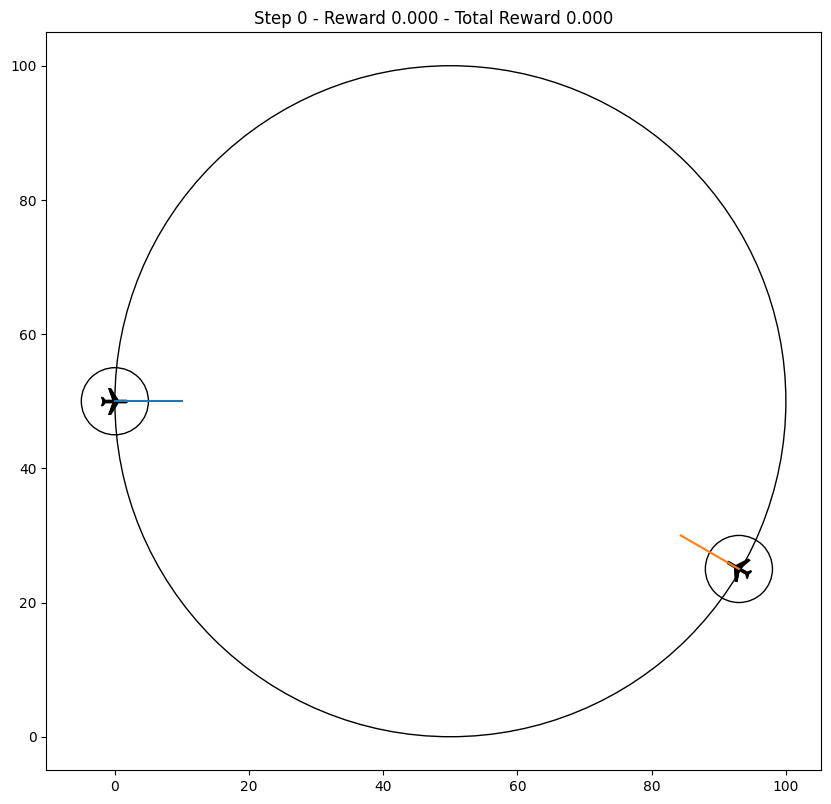

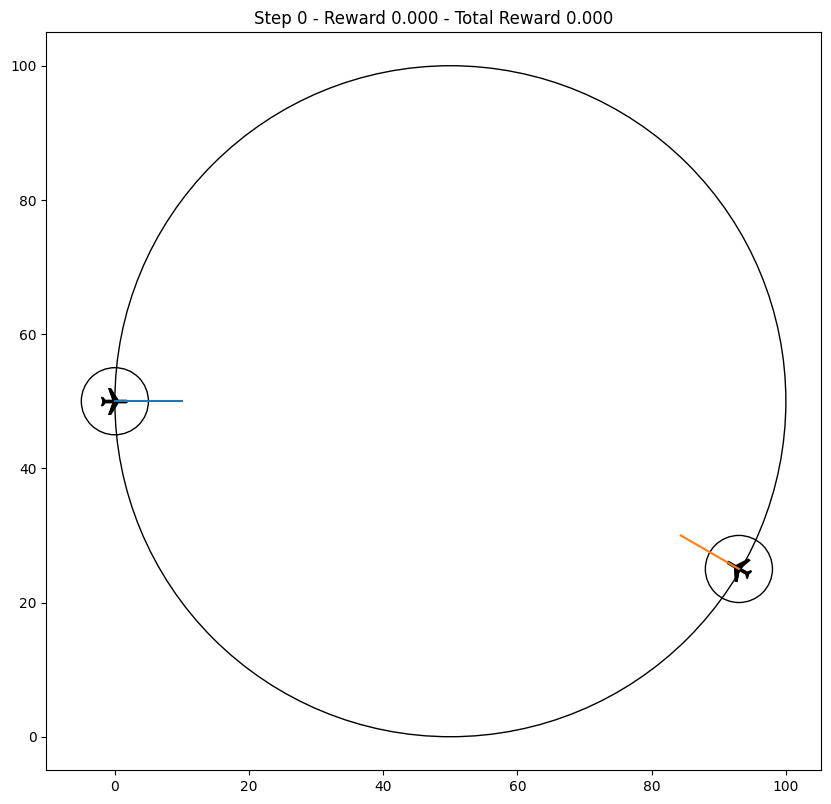

In [14]:
env.reset()
# env.observation_func()
env.render()

In [15]:
"""
Reward = a1 * Reward_Step +
         a2 * Reward_Deviation +
         a3 * Reward_LOS +
         a4 * Reward_Maneuvering +
         a5 * Reward_Not_Reached +
         a6 * Reward_Reached

Reward_Params_i = [a1, a2, a3, a4, a5, a6]
"""

Reward_Params = [-0.2, 0, -1000, -1, -1000, 100]

In [16]:
# change the name of the model to be saved
name = 'CustomEnv_PPO_crossing_90'

## Task 3



### Evaluate model convergence with Tensorboard
Run the code below to train the agent and log the trainig information on to Tensorboard

In [ ]:

from stable_baselines3.ppo import MlpPolicy
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

env = CustomEnv(Reward_Params)

model = PPO(MlpPolicy, env,gamma=0.99, tensorboard_log='./Log/CustomEnv/', verbose = 1)

model.learn(total_timesteps=200000, tb_log_name=name, progress_bar = True)
model.save("./Models/CustomEnv/circle/" +name)

# Evaluate the trained model
eval_env = CustomEnv(Reward_Params)
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200,701/200,000  [ 0:07:02 < 0:00:00 , 497 it/s ]

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


mean_reward=-213678.09 +/- 172444.0760105965


## Task 4:


### Change the reward parameters in the constructor of the CustomEnv class

In [ ]:
#load model for visualization

name = 'CustomEnv_PPO_crossing_90'
model = PPO.load("./Models/CustomEnv/circle/" +name)

### Create a gif file for visualization

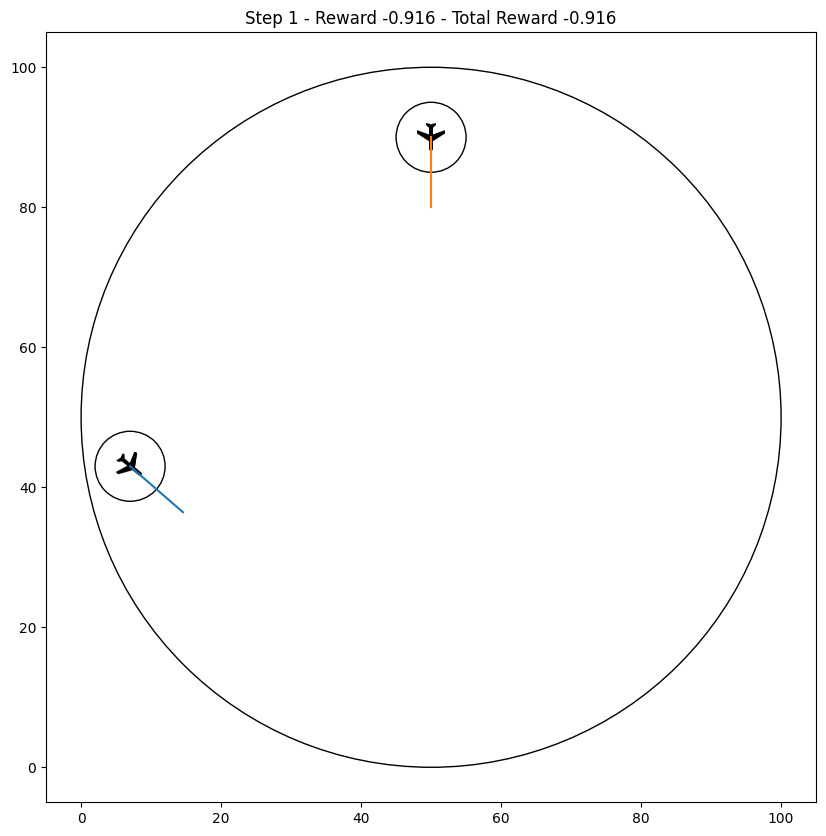

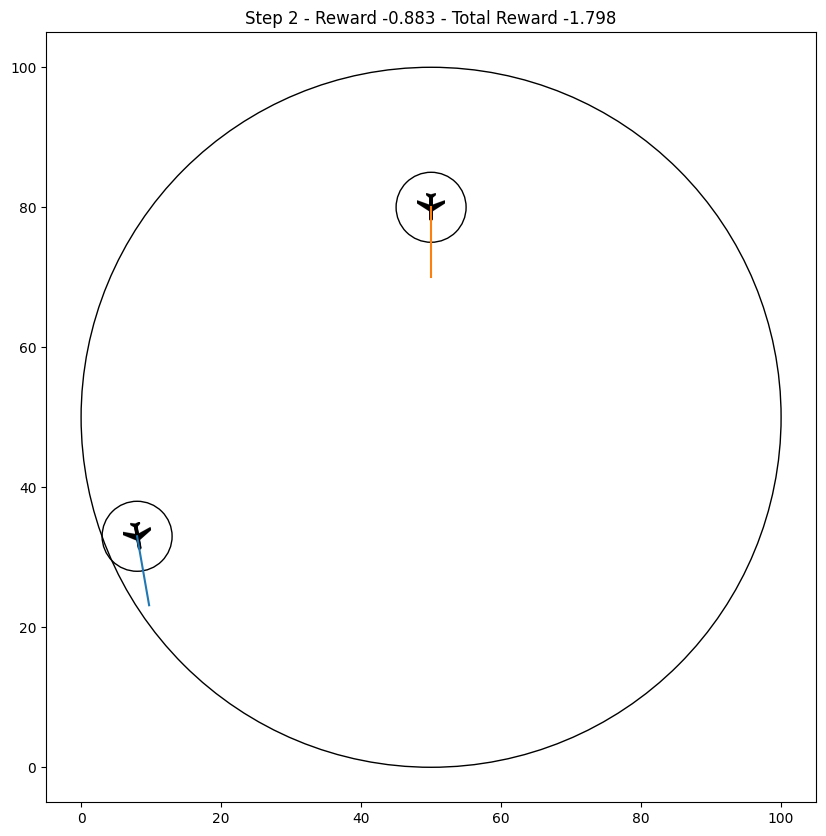

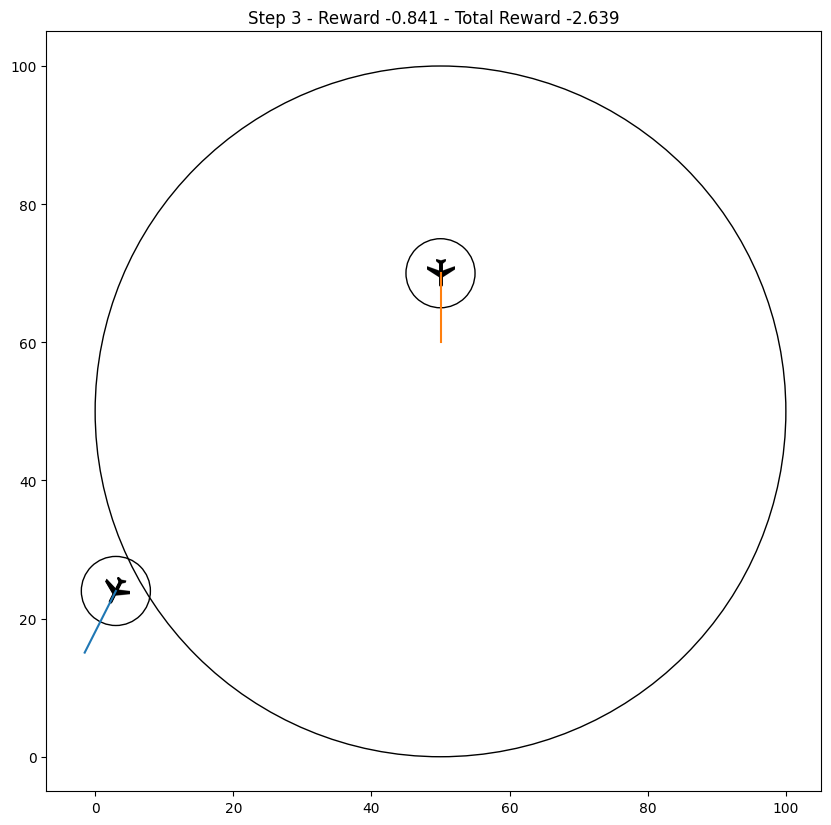

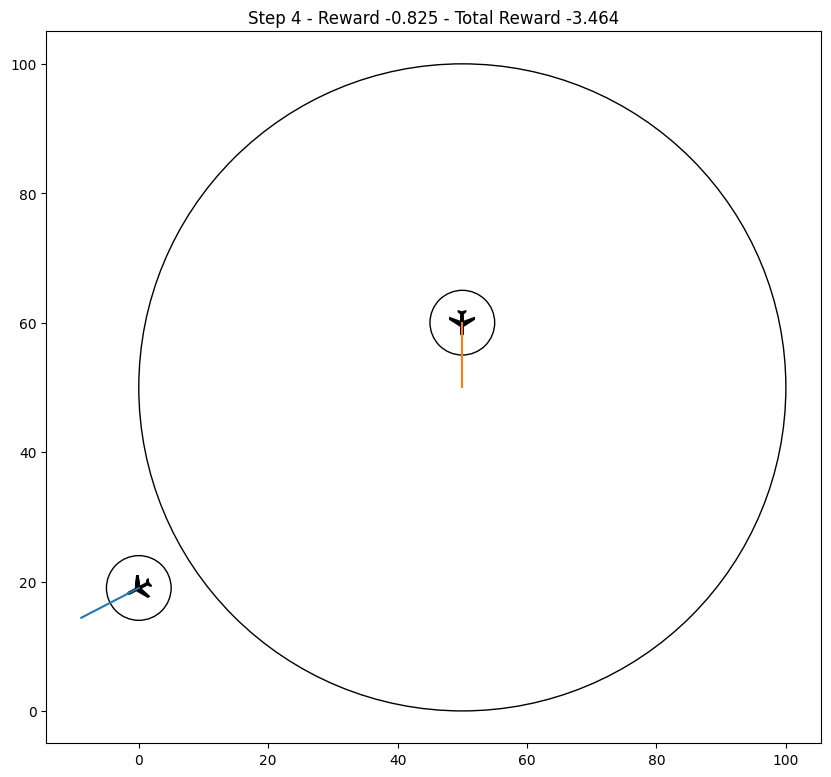

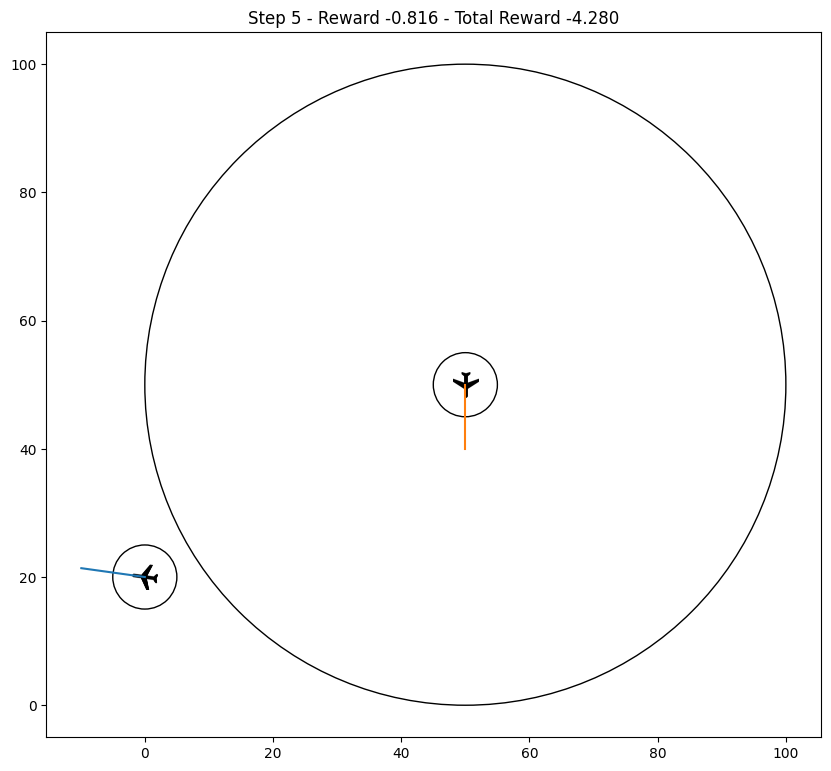

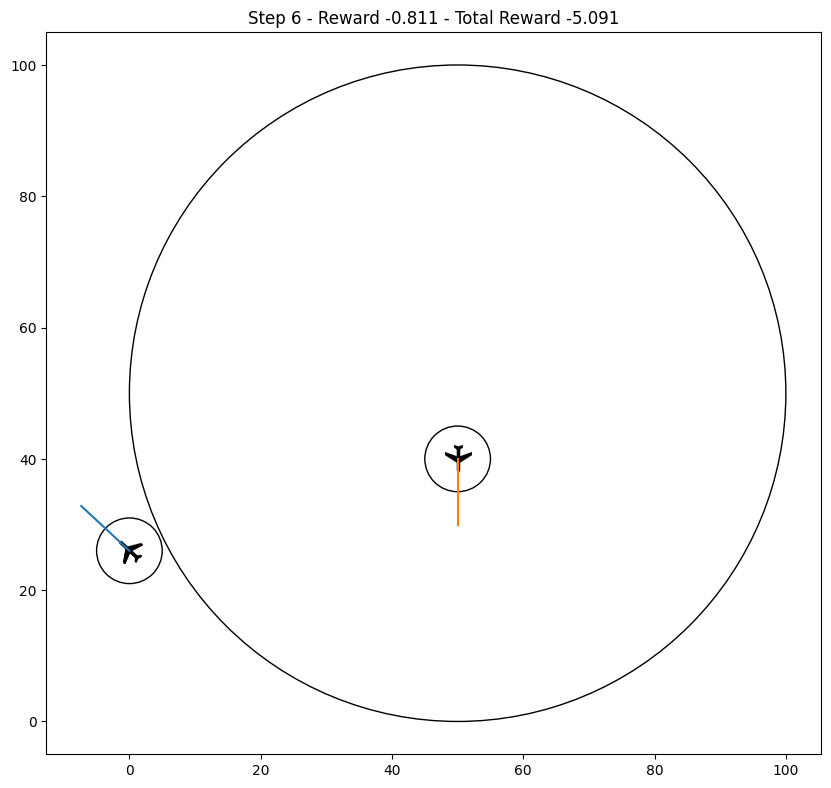

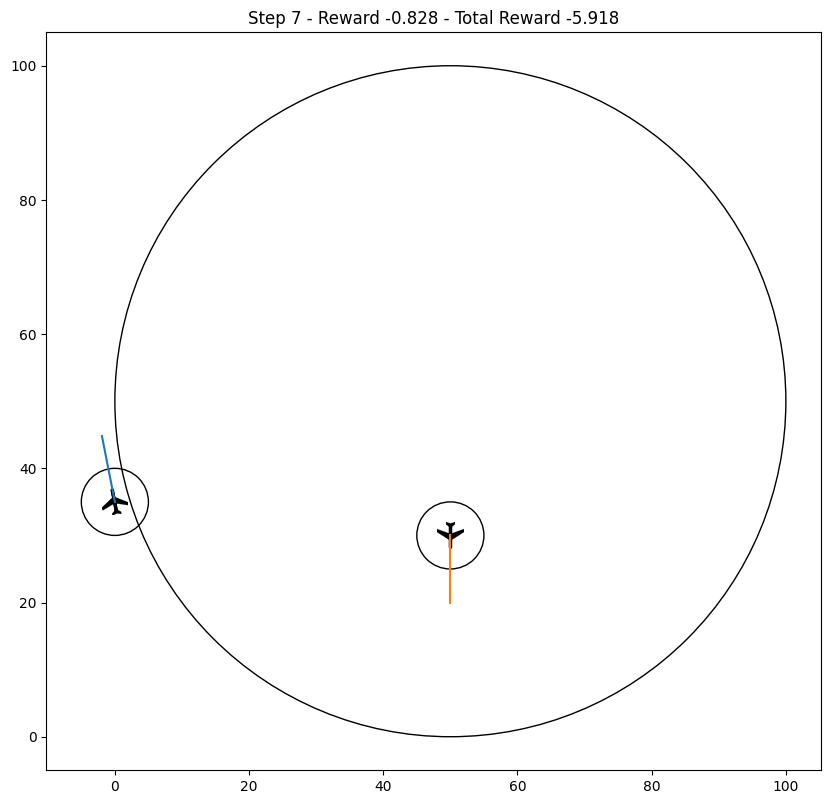

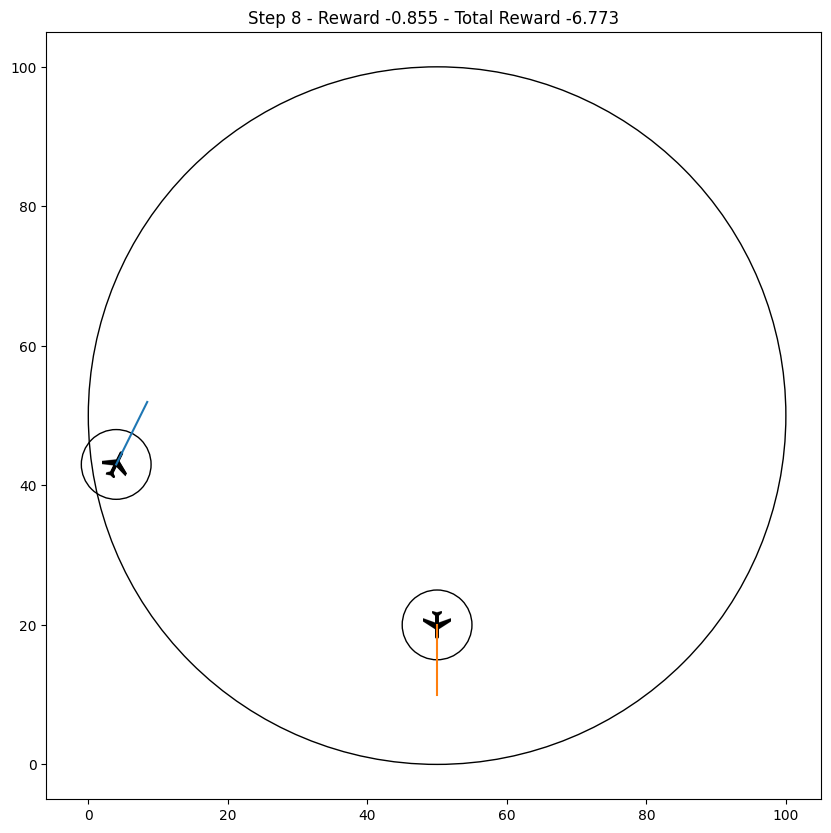

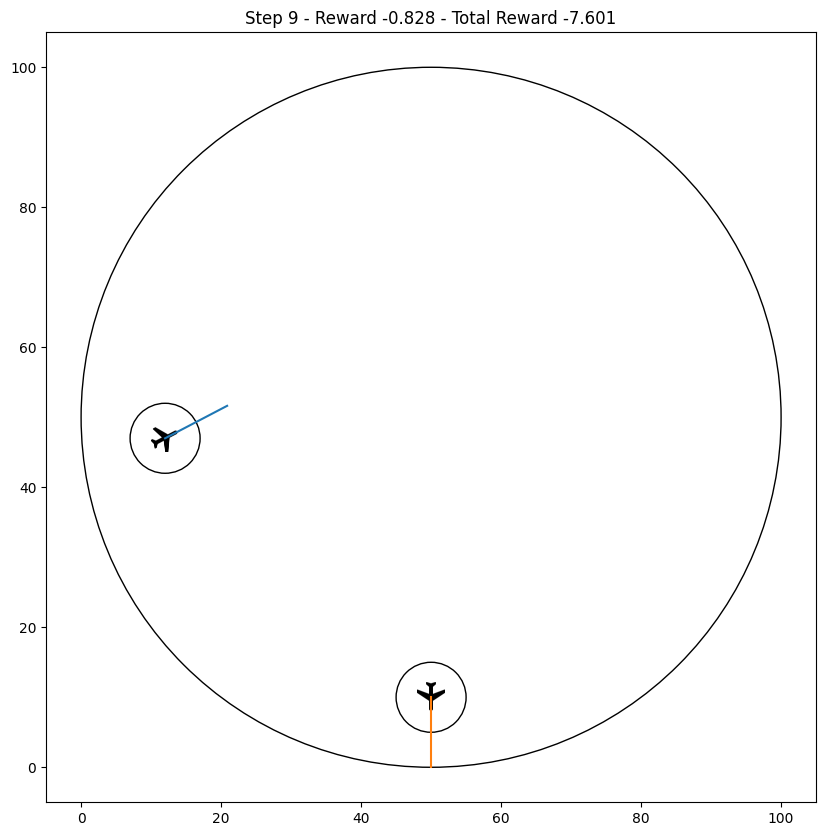

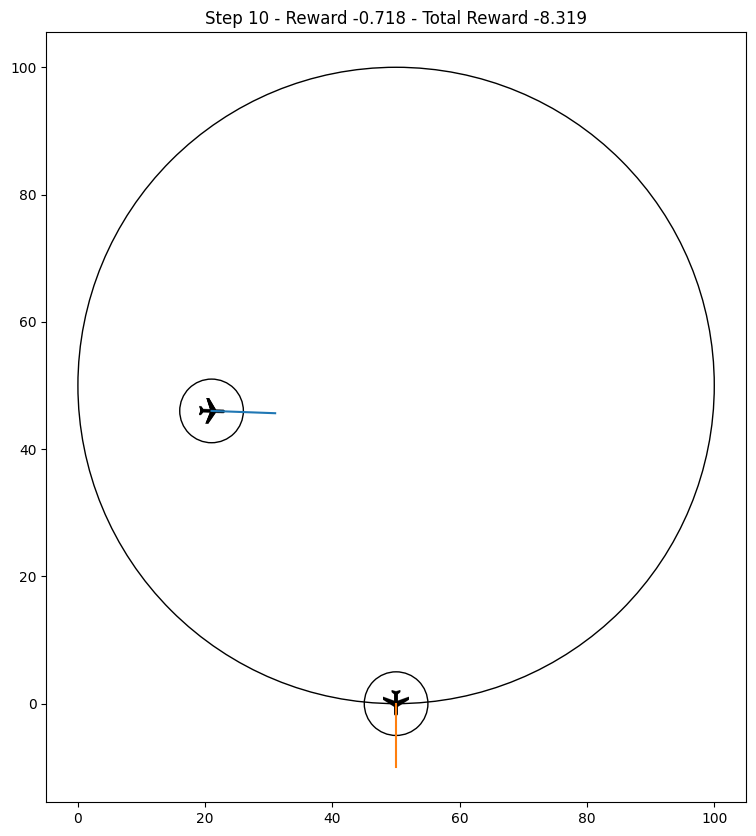

In [ ]:
import glob
import os
from PIL import Image
import time

# Visualize 1 episode using the trained policy and store the image into selected folder
env = CustomEnv(Reward_Params)
obs, info = env.reset()

for i in range(10):
    # Take a random action
    action, state_ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = env.step(action)

    # Render the game
    c = env.render(False,'./Images/CustomEnv/')
    if done == True:
        break

# Generate the GIF from set of images
# filepaths
fp_in = "./Images/CustomEnv/image_*.png"
fp_out = "./Images/{}.gif".format(name)

# time.sleep(2)
imgs = []
for f in sorted(glob.glob(fp_in)):
    imgs.append(Image.open(f))
    os.remove(f)
    # imgs[-1].close()

img = imgs[0]  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=len(imgs)*20, loop=0)